<div style="float:left;font-size:20px;">
    <h1>Solar Panel Classification</h1>
</div><div style="float:right;"><img src="../assets/banner.jpg"></div>

Data:
- Shape = (180, 180, 4) -> (180, 180, 3) by removing alpha
- Features = 97200
- Metrics: 35 epochs ~ 0.9948 (Expect ~ 0.95 given data distribution)

<hr>

Todo:
- Data augmentation
- Dropout
- Learning rate schedules
- TensorBoard

Ideas:
- Hypyeropt/Hyperas for hyperparameter optimisation
- Combat overfitting
    - Feature enrichment: Squares, blue/white boundaries
    - Rotations and scale transforms to enrich dataset
- Image denoising and smoothing
- Pretrained models and transfer learning
- Compression via PCA dimensionality reduction or clustering
- Compression via greyscale/reducing resolution

In [257]:
data_dir = 'V:/MachineLearning/SolarPanelClassification/tagging1/'
nosolar_dir = data_dir + 'no_solar/'
solar_dir = data_dir + 'contains_solar/'
IMG_HEIGHT = 180
IMG_WIDTH = 180
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
image_batch_size = 2843    # Number of images to load

In [258]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           # Data augmentation
                                           horizontal_flip=True,
                                           #rotation_range=45,
                                           #zoom_range=0.5,
                                          )
train_data_gen = train_image_generator.flow_from_directory(batch_size=image_batch_size,
                                                           directory=data_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2843 images belonging to 2 classes.


In [259]:
X, y = next(train_data_gen)

In [117]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [144]:
len(X)

32

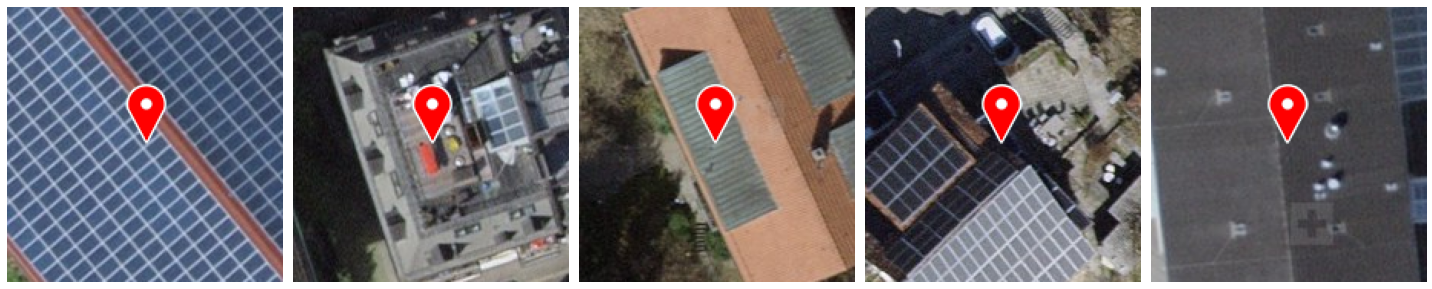

In [163]:
plotImages(X[:5])

In [168]:
import os
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def load_samples(nosolar_dir, solar_dir, solar_max_samples=None, nosolar_max_samples=None):
    """Load all samples into numpy arrays. Remove redundant alpha channel"""
    nosolar_files = [nosolar_dir + x for x in os.listdir(nosolar_dir) if x[-4:] == '.png']
    solar_files = [solar_dir + x for x in os.listdir(solar_dir) if x[-4:] == '.png']
   
    if nosolar_max_samples:
        nosolar_files = nosolar_files[:nosolar_max_samples]
    if solar_max_samples:
        solar_files = solar_files[:solar_max_samples]
    
    nosolar_data = [np.array(Image.open(nosolar_file))[:,:,:3]/255 for nosolar_file in nosolar_files]
    solar_data = [np.array(Image.open(solar_file))[:,:,:3]/255 for solar_file in solar_files]
    
    data_shape = np.array(Image.open(nosolar_files[0]))[:,:,:3].shape
    X = np.concatenate([nosolar_data, solar_data])
    y = np.concatenate([np.zeros((len(nosolar_files))), np.ones((len(solar_data)))])
    label = [x.replace('.png', '') for x in nosolar_files] + [x.replace('.png', '') for x in nosolar_files]
    return X, y, label, data_shape

In [169]:
solar_max_samples = None
nosolar_max_samples = None
X, y, label, data_shape = load_samples(nosolar_dir, solar_dir, solar_max_samples=solar_max_samples, nosolar_max_samples=nosolar_max_samples)

In [170]:
X.shape

(2843, 180, 180, 3)

In [156]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [171]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

5.1% of datasets have solar panels
-> Expect the "No solar panel" model to have an accuracy of 94.9%

In [162]:
np.mean(y_train), np.mean(y_test)

(0.945591, 0.96061885)

## Visualise

In [49]:
def plot_image(X, data_shape):
    data = X
    #data = data.reshape(data_shape)
    plt.imshow(data, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

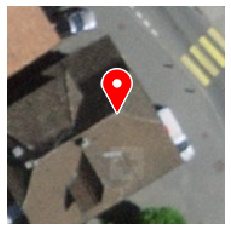

In [50]:
# Background
plot_image(X[0], data_shape)

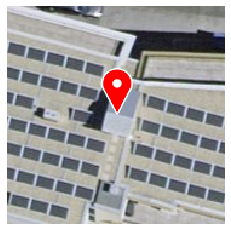

In [51]:
# Signal
plot_image(X[-3], data_shape)

## Dimensionality reduction

In [11]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
# Without scaling (not advised for PCA)
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

366

Only need 364 dimensions to provide a 95% variance explain --> 364/97200 = 3.7% of original data

In [13]:
pca = PCA(n_components=364)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


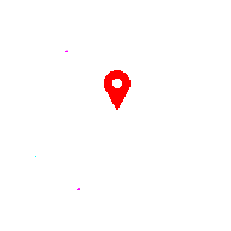

In [14]:
# PCA is dominated by the red pointer
plot_image(X_recovered[-1], data_shape)

Attempt to clean pointer from image, the StandardScaler of all images should be zero for the pointer as it is unchanging.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean.astype(np.float64))

In [71]:
#mask = [x < 255 for i, x in enumerate(X_train[-1])]
mask = [x != 0 for i, x in enumerate(X_train_scaled[-1])]
X_train_clean = [X_t*mask for X_t in X_train]

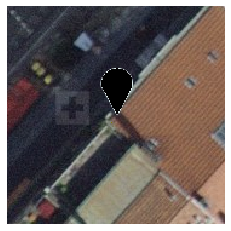

In [72]:
plot_image(X_train[-1]*mask, data_shape)

In [73]:
pca.fit(X_train_clean)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1
d

1

In [77]:
pca = PCA(n_components=850)
X_reduced = pca.fit_transform(X_train_clean)
X_recovered = pca.inverse_transform(X_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


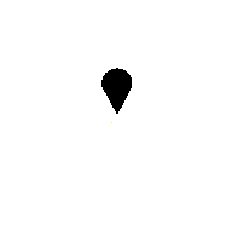

In [78]:
# Compressed image
plot_image(X_recovered[-1], data_shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


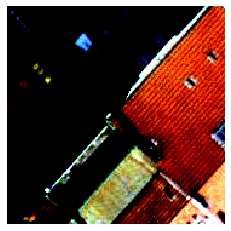

In [79]:
# Original image scaled (this is an average of all images and not very useful)
plot_image(X_train_scaled[-1], data_shape)

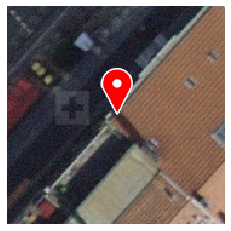

In [20]:
# Original image
plot_image(X_train[-1], data_shape)

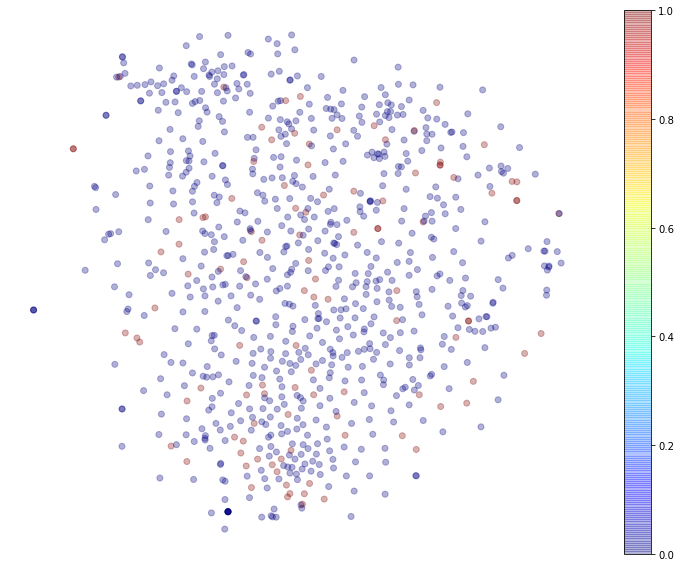

In [82]:
# use t-SNE to reduce dimensionality down to 2D and plot
from sklearn.manifold import TSNE
n = -1

tsne = TSNE(n_components=2, random_state=42)
X_train_tnse = tsne.fit_transform(X_train[:n])

plt.figure(figsize=(13, 10))
plt.scatter(X_train_tnse[:, 0], X_train_tnse[:, 1], c=y_train[:n], cmap="jet", alpha=0.3)
plt.axis('off')
plt.colorbar()
plt.show()

## Basic CNN

In [260]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# 10 epochs - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
model = models.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=input_shape),
    layers.MaxPooling2D(),
    #layers.Dropout(0.2),
    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 7, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #layers.Dropout(0.2),
    layers.Flatten(),
    #layers.Dense(512, activation='relu'),
    #layers.Dense(2, activation='softmax')
    layers.Dense(1)
    ]
)

# 10 epochs - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
lenet_5_model = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), strides=1,  activation='relu', input_shape=input_shape, padding='same'), #C1
    layers.AveragePooling2D(pool_size=(2, 2), strides=2), #S2
    layers.Conv2D(16, kernel_size=(5, 5), strides=1, activation='relu', padding='valid'), #C3
    layers.AveragePooling2D(pool_size=(2, 2), strides=2), #S4
    layers.Flatten(), #Flatten
    layers.Dense(120, activation='relu'), #C5
    layers.Dense(84, activation='relu'), #F6
    #layers.Dense(2, activation='softmax')  # Output layer
    layers.Dense(1)
])

cnn1 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    #layers.Dense(10, activation='softmax')
    layers.Dense(1)
])

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

### Model selection

In [261]:
model = model
model = lenet_5_model
#model = cnn1

In [ ]:
model.summary()

In [85]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Train the model

In [262]:
# Learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,)

In [263]:
#score_output = layers.Dense(1, name="score_output")(x)
#class_output = layers.Dense(2, activation="softmax", name="class_output")(x)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'], #, 'recall', 'AUC'], 
              #outputs=[score_output, class_output]
             )

history = model.fit(X_train, y_train, batch_size=256, epochs=10, 
                    validation_split=0.2)

Train on 1705 samples, validate on 427 samples
Epoch 1/10
1705/1705 [==============================] - 16s 9ms/sample - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
Epoch 2/10
1705/1705 [==============================] - 11s 7ms/sample - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
Epoch 3/10
1705/1705 [==============================] - 11s 6ms/sample - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
Epoch 4/10
1705/1705 [==============================] - 11s 6ms/sample - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
Epoch 5/10
1705/1705 [==============================] - 11s 6ms/sample - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
Epoch 6/10
1705/1705 [==============================] - 11s 7ms/sample - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0.9485
Epoch 7/10
1705/1705 [==============================] - 11s 6ms/sample - loss: 0.7780 - acc: 0.9496 - val_loss: 0.7947 - val_acc: 0

711/711 - 5s - loss: 14.4771 - acc: 0.0506


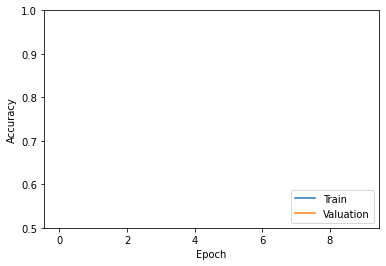

In [213]:
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label = 'Valuation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [198]:
print(f'Accuracy = {test_acc:.2f}, Loss = {test_loss:.2f}')

Accuracy = 0.95, Loss = 0.78


## Metrics

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

In [188]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

711/711 [==============================] - 4s 6ms/sample
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       675
         1.0       0.00      0.00      0.00        36

    accuracy                           0.95       711
   macro avg       0.47      0.50      0.49       711
weighted avg       0.90      0.95      0.92       711



C:\Users\Mark\.conda\envs\CatAna\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [183]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_bool)

array([[675,   0],
       [ 36,   0]], dtype=int64)

# TO ADD

### Reading
https://www.tensorflow.org/guide/keras/train_and_evaluate

In [ ]:
# Learning rate scheduler
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [ ]:
# TensorBoard
# Run this first: tensorboard --logdir=/full_path_to_your_logs
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

## MNIST classification

In [1]:
import tensorflow as tf
num_classes = 10
img_rows, img_cols = 28, 28
num_channels = 1
input_shape = (img_rows, img_cols, num_channels)
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

C:\Users\Mark\.conda\envs\CatAna\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
# cd /d R:\Projects\JupyterNotebooks\Analysis\Graph
# tensorboard --logdir=R:\Projects\JupyterNotebooks\Analysis\Graph\

In [2]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [] #[tf.keras.callbacks.TensorBoard('./keras')]
model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 5s 75us/sample - loss: 0.6517 - acc: 0.8371 - val_loss: 0.3587 - val_acc: 0.9054
Epoch 2/25
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3379 - acc: 0.9057 - val_loss: 0.2934 - val_acc: 0.9189
Epoch 3/25
60000/60000 [==============================] - 4s 68us/sample - loss: 0.2892 - acc: 0.9192 - val_loss: 0.2609 - val_acc: 0.9282
Epoch 4/25
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2583 - acc: 0.9276 - val_loss: 0.2389 - val_acc: 0.9317
Epoch 5/25
60000/60000 [==============================] - 4s 70us/sample - loss: 0.2351 - acc: 0.9342 - val_loss: 0.2194 - val_acc: 0.9379
Epoch 6/25
60000/60000 [==============================] - 4s 67us/sample - loss: 0.2165 - acc: 0.9395 - val_loss: 0.2056 - val_acc: 0.9418
Epoch 7/25
60000/60000 [===========

## Evaluate performance

In [ ]:

# --------------------------------
# Confusion matrix
# --------------------------------
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
"""
array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)
"""

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)
"""
precision = 0.769 => 76.9% of all positive predictions were correct
recall = 0.801    => 80.1% of all true positives were predicted
"""
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
"""
F1 score = 0.785
"""


# --------------------------------
# Measure Precision and Recall
# --------------------------------
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("precision_recall_vs_threshold_plot")
plt.show()


def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()


# --------------------------------
# ROC curves
# --------------------------------
# Receiver operating characteristic

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

# Compute Area Under Curve (AUC) score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
"""
AUC = 0.9624496555967156
"""